Importing all libraries that'll be required.


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# from sklearn.metrics import confusion_matrix
from typing import Counter
%matplotlib inline


In [31]:
# Surpress warnings:
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn


In [32]:
def plot_confusion_matrix(y, y_predict, t='Confusion Matrix', cm=None):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix
    if cm is None:
        cm = confusion_matrix(y, y_predict)
    fig, ax = plt.subplots(figsize=(4, 3))
    sns.heatmap(cm, annot=True, ax=ax, cmap='mako', fmt=',d').set_title(
        t, fontsize=12)
    # sns.color_palette("mako", as_cmap=True)
    ax.set_xlabel('Predicted labels', fontsize=10)
    ax.set_ylabel('True labels', fontsize=10)
    # ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['BENIGN', 'MALIGNANT'], fontsize=8)
    ax.yaxis.set_ticklabels(['BENIGN', 'MALIGNANT'], fontsize=8)
    plt.show()


In [33]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(true_y, y_prob):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


Importing data


In [34]:
df = pd.read_csv('train40Features.csv')
target = pd.read_csv('train.csv')

In [35]:
# df.head()

In [36]:
# target.head()

In [37]:
# df.isnull().sum()

In [38]:
# for i in range(len(df.columns)):
#     if df.iloc[:,i].isnull().sum():
#         print(df.columns[i])

In [39]:
for i in range(len(target.columns)):
    if target.iloc[:, i].isnull().sum():
        print(target.columns[i], target.iloc[:, i].isnull().sum())


sex 65
age_approx 68
anatom_site_general_challenge 527


In [40]:
target['sex'].value_counts()

male      17080
female    15981
Name: sex, dtype: int64

In [41]:
# df.dtypes

In [42]:
#adding target column to our train dataset
df['target'] = target['target']

In [43]:
df.drop('V1',axis = 1, inplace = True) 

In [44]:
# df.head()

In [45]:
columns = ['sex','age','anatomy','V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8','V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34','V35','V36','target']
df.columns = columns
# df.head()

In [46]:
# df.describe()

In [47]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN


In [48]:
x = {}
y = {}
x_train = {}
x_test = {}
y_train = {}
y_test = {}

In [49]:
# x= df[df['target'] == 1]

In [50]:
from imblearn.over_sampling import RandomOverSampler
ros=RandomOverSampler(random_state=0, sampling_strategy=0.08)
x['ROS'], y['ROS']= ros.fit_resample(df.drop('target',axis=1),df['target'])
x_train['ROS'], x_test['ROS'], y_train['ROS'], y_test['ROS'] = train_test_split(x['ROS'], y['ROS'], test_size=0.25, random_state=42)
print(y_train['ROS'].value_counts(),'\n',y_test['ROS'].value_counts())
#normalizing the data
st_x= StandardScaler()    
x_train['ROS']= st_x.fit_transform(x_train['ROS'])    
x_test['ROS']= st_x.transform(x_test['ROS']) 

0    24416
1     1942
Name: target, dtype: int64 
 0    8126
1     661
Name: target, dtype: int64


In [51]:
smote= SMOTE(random_state=0, sampling_strategy=0.08)
x['SMOTE'], y['SMOTE']= smote.fit_resample(df.drop('target',axis=1),df['target'])
x_train['SMOTE'], x_test['SMOTE'], y_train['SMOTE'], y_test['SMOTE'] = train_test_split(x['SMOTE'], y['SMOTE'], test_size=0.25, random_state=42)
print(y_train['SMOTE'].value_counts(),'\n',y_test['SMOTE'].value_counts())
st_x= StandardScaler()
x_train['SMOTE']= st_x.fit_transform(x_train['SMOTE'])
x_test['SMOTE']= st_x.transform(x_test['SMOTE'])

0    24416
1     1942
Name: target, dtype: int64 
 0    8126
1     661
Name: target, dtype: int64


In [52]:

adasyn= ADASYN(random_state=0, sampling_strategy=0.08)
x['ADASYN'], y['ADASYN']= adasyn.fit_resample(df.drop('target',axis=1),df['target'])
x_train['ADASYN'], x_test['ADASYN'], y_train['ADASYN'], y_test['ADASYN'] = train_test_split(x['ADASYN'], y['ADASYN'], test_size=0.25, random_state=42)
print(y_train['ADASYN'].value_counts(),'\n',y_test['ADASYN'].value_counts())
st_x= StandardScaler()
x_train['ADASYN']= st_x.fit_transform(x_train['ADASYN'])
x_test['ADASYN']= st_x.transform(x_test['ADASYN'])

0    24360
1     2166
Name: target, dtype: int64 
 0    8182
1     660
Name: target, dtype: int64


In [53]:
ost = ['ROS', 'SMOTE', 'ADASYN']
for i in ost:
    print(i, x_train[i].shape, x_test[i].shape,
          y_train[i].shape, y_test[i].shape)
    print(Counter(y_train[i]), Counter(y_test[i]), "\n\n")


ROS (26358, 39) (8787, 39) (26358,) (8787,)
Counter({0: 24416, 1: 1942}) Counter({0: 8126, 1: 661}) 


SMOTE (26358, 39) (8787, 39) (26358,) (8787,)
Counter({0: 24416, 1: 1942}) Counter({0: 8126, 1: 661}) 


ADASYN (26526, 39) (8842, 39) (26526,) (8842,)
Counter({0: 24360, 1: 2166}) Counter({0: 8182, 1: 660}) 




In [54]:
def report(yt, y_pred):
    d = {"Accuracy": accuracy_score(yt, y_pred),
         "Precision": precision_score(yt, y_pred),
         "Recall": recall_score(yt, y_pred),
         "F1 score": f1_score(yt, y_pred)}
    rep = pd.DataFrame(d, index=[0])
    print(rep)


In [55]:
from sklearn.linear_model import LogisticRegression
cmm = []
ust = ['ROS', 'SMOTE', 'ADASYN']
clf = LogisticRegression()
for i in ust:
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i], y_pred))
    print(i+" Oversampling :")
    report(y_test[i], y_pred)
    print("\n")


ROS Oversampling :
   Accuracy  Precision    Recall  F1 score
0  0.925003   0.535714  0.022693  0.043541


SMOTE Oversampling :
   Accuracy  Precision   Recall  F1 score
0  0.942415   0.928177  0.25416   0.39905


ADASYN Oversampling :
   Accuracy  Precision    Recall  F1 score
0  0.943339   0.949153  0.254545  0.401434




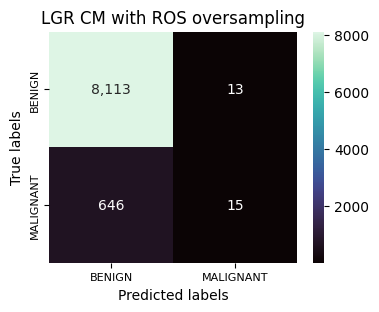

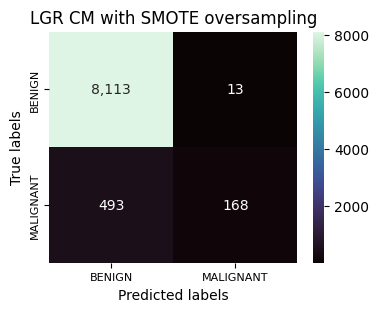

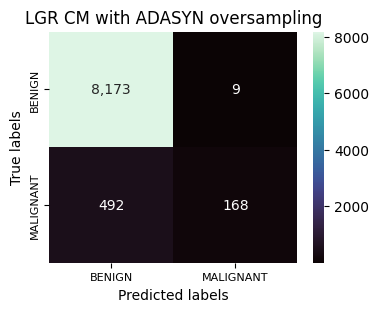

In [56]:
for n, i in enumerate(cmm):
    plot_confusion_matrix(0, 0, t=f'LGR CM with {ust[n]} oversampling', cm=i)


In [57]:
cmm = []
clf = DecisionTreeClassifier(splitter='best')
for i in ust:
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i],y_pred))
    print(i+" Oversampling :")
    report(y_test[i], y_pred)
    print("\n")
# print(cmm)


ROS Oversampling :
   Accuracy  Precision   Recall  F1 score
0  0.974735   0.765417  0.95764  0.850806


SMOTE Oversampling :
   Accuracy  Precision    Recall  F1 score
0  0.946284   0.631433  0.686838  0.657971


ADASYN Oversampling :
   Accuracy  Precision    Recall  F1 score
0  0.941755   0.599451  0.662121   0.62923




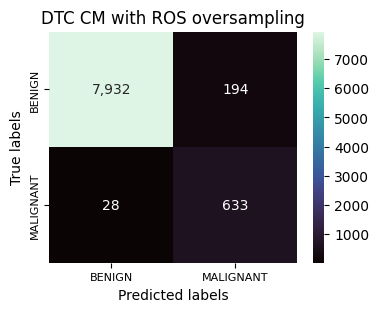

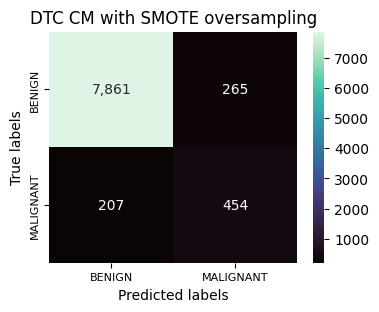

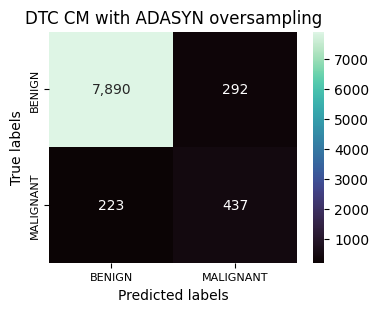

In [58]:
for n, i in enumerate(cmm):
    plot_confusion_matrix(0, 0, t=f'DTC CM with {ust[n]} oversampling', cm=i)


In [59]:
# clf = DecisionTreeClassifier()

# # Train Decision Tree Classifer
# clf = clf.fit(x_train,y_train)

# #Predict the response for test dataset
# y_pred = clf.predict(x_test)

# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [60]:
# cm = confusion_matrix(y_test, y_pred)
# cm


In [61]:
# corr = df.corr()
# # corr
# corr.head()

In [62]:
# corr.shape

In [63]:
# df['target'].value_counts()
# x = df.drop('target',axis = 1)


In [64]:
# x_train, x_test, y_train, y_test = train_test_split(x, df['target'], test_size=0.25, random_state=4)

In [65]:
# plot_roc_curve(y_test, y_pred)


In [66]:
#KNN MODEL
# from sklearn.neighbors import KNeighborsClassifier  
# classifier = KNeighborsClassifier(n_neighbors=4)  # metric='minkowski', p=2
# classifier.fit(x_train, y_train)
# y_pred= classifier.predict(x_test)  
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [67]:
# cm = confusion_matrix(y_test, y_pred)
# cm


In [68]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=6)
cmm = []
for i in ust:
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    print(i+" Oversampling :")
    report(y_test[i], y_pred)
    print("\n")


ROS Oversampling :
   Accuracy  Precision    Recall  F1 score
0  0.935359   0.597895  0.429652       0.5


SMOTE Oversampling :
   Accuracy  Precision    Recall  F1 score
0  0.941049   0.691689  0.390318  0.499033


ADASYN Oversampling :
   Accuracy  Precision    Recall  F1 score
0  0.940511   0.665025  0.409091  0.506567




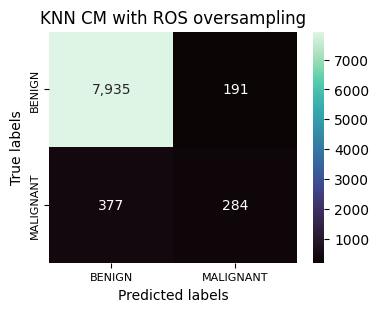

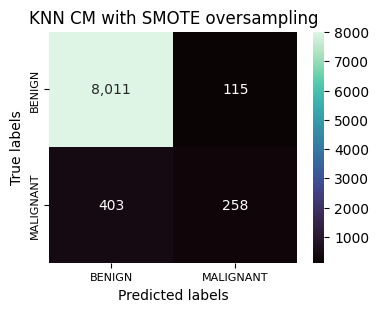

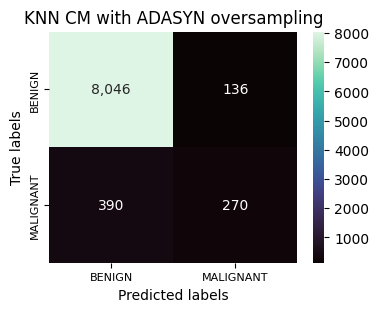

In [69]:
for n, i in enumerate(cmm):
    plot_confusion_matrix(0, 0, t=f'KNN CM with {ust[n]} oversampling', cm=i)


In [70]:
# plot_roc_curve(y_test, y_pred)


In [71]:
# #SVM model
# classifier = SVC(kernel='linear', random_state=0)
# classifier.fit(x_train, y_train) 
# y_pred= classifier.predict(x_test)
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [72]:
# cm = confusion_matrix(y_test,y_pred)
# cm
# yhat = classifier.predict(x_test)
# plot_confusion_matrix(y_test,yhat, 'Confusion Matrix for Decision Tree')

In [73]:
# cm = confusion_matrix(y_test, yhat)
# cm


In [74]:
# tree= DecisionTreeClassifier(max_depth=100)
# tree.fit(x_train,y_train)
# print(tree.max_depth)

In [75]:
# tree_cv.predict(x_test)

In [76]:
# yhat = tree_cv.predict(x_test)
# plot_confusion_matrix(y_test,yhat, 'Confusion Matrix for Decision Tree')

In [77]:
cmm = []
clf = SVC()
for i in ust:
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i], y_pred))
    print(i+" Undersampling :")
    report(y_test[i], y_pred)
    print("\n")


ROS Undersampling :
   Accuracy  Precision    Recall  F1 score
0  0.925799        1.0  0.013616  0.026866


SMOTE Undersampling :
   Accuracy  Precision    Recall  F1 score
0  0.926141       0.75  0.027231  0.052555


ADASYN Undersampling :
   Accuracy  Precision    Recall  F1 score
0  0.925809        0.7  0.010606  0.020896




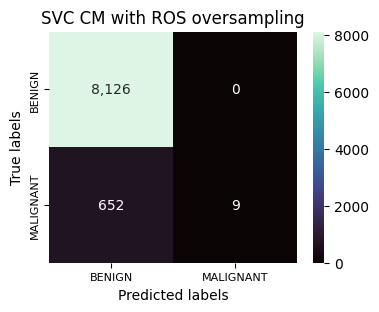

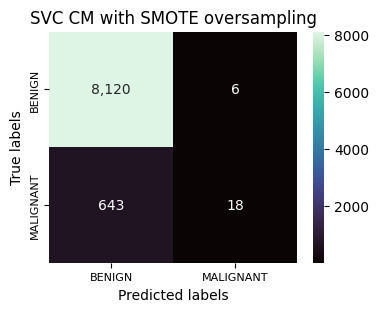

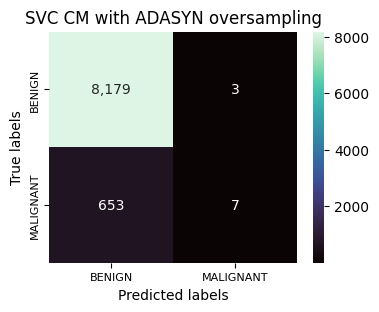

In [78]:
for n, i in enumerate(cmm):
    plot_confusion_matrix(0, 0, t=f'SVC CM with {ust[n]} oversampling', cm=i)


In [79]:
# from sklearn.ensemble import RandomForestClassifier
# rfc = RandomForestClassifier(random_state=42)
# # param_grid = {
#     'n_estimators': [200, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth': [4, 5, 6, 7, 8],
#     'criterion': ['gini', 'entropy']
# }


In [80]:
# CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
# rfc.fit(x_train, y_train)


In [81]:
# CV_rfc.best_params_

In [82]:
# ypred= CV_rfc.predict(x_test)
# confusion_matrix(y_test,ypred, "Confusion Matrix for Random Forest")

In [83]:
# rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, criterion='gini')
# rfc1.fit(x_train, y_train)


In [84]:
# pred = rfc1.predict(x_test)


In [85]:
# print("Accuracy for Random Forest on CV data: ", accuracy_score(y_test, pred))
# rfc1.score(x_test, y_test)

In [86]:
# yhat = rfc1.predict(x_test)
# plot_confusion_matrix(y_test,yhat, 'Confusion Matrix for Random Forest')

In [87]:
from sklearn.ensemble import RandomForestClassifier
cmm=[]
for i in ust:
    rfc = RandomForestClassifier(random_state=42)
    rfc.fit(x_train[i], y_train[i])
    y_pred = rfc.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    print(i+" Oversampling :")
    report(y_test[i], y_pred)
    print("\n")

ROS Oversampling :
   Accuracy  Precision    Recall  F1 score
0  0.995675   0.985959  0.956127  0.970814


SMOTE Oversampling :
   Accuracy  Precision    Recall  F1 score
0  0.959941   0.966767  0.484115  0.645161


ADASYN Oversampling :
   Accuracy  Precision    Recall  F1 score
0  0.958833   0.965409  0.465152  0.627812




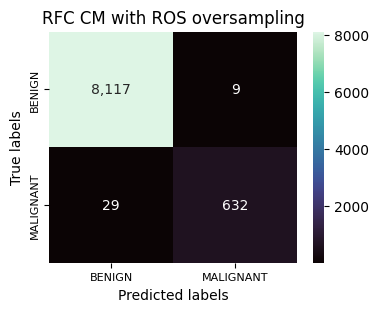

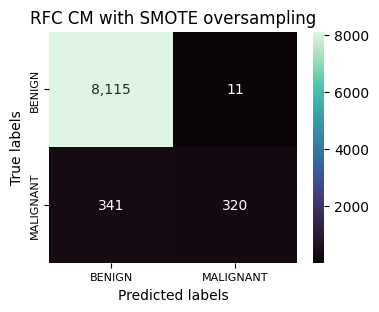

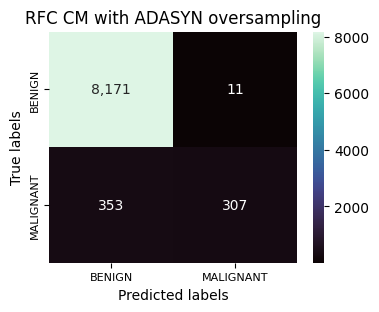

In [88]:
for n, i in enumerate(cmm):
    plot_confusion_matrix(0, 0, t=f'RFC CM with {ust[n]} oversampling', cm=i)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001, beta_1=0.9,
                 beta_2=0.999, epsilon=1e-07, amsgrad=False)
ANN_model = keras.Sequential()
ANN_model.add(
    Dense(100, input_dim=39, kernel_initializer='normal', activation='relu'))
ANN_model.add(Dense(20, activation='relu'))
ANN_model.add(Dropout(0.1))
ANN_model.add(Dense(50, activation='relu'))
ANN_model.add(Dropout(0.1))
ANN_model.add(Dense(100, activation='relu'))
ANN_model.add(Dropout(0.1))
ANN_model.add(Dense(150, activation='relu'))
# ANN_model.add(Dense(400, activation='relu'))
ANN_model.add(Dense(200, activation='relu'))

ANN_model.add(Dropout(0.1))
ANN_model.add(Dense(100, activation='relu'))
ANN_model.add(Dropout(0.1))
ANN_model.add(Dense(50, activation='relu'))
ANN_model.add(Dropout(0.1))
ANN_model.add(Dense(25, activation='relu'))
ANN_model.add(Dropout(0.1))
ANN_model.add(Dense(1, activation='sigmoid'))
ANN_model.compile(loss='mse', optimizer='adam')
ANN_model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 100)               4000      
                                                                 
 dense_61 (Dense)            (None, 20)                2020      
                                                                 
 dropout_42 (Dropout)        (None, 20)                0         
                                                                 
 dense_62 (Dense)            (None, 50)                1050      
                                                                 
 dropout_43 (Dropout)        (None, 50)                0         
                                                                 
 dense_63 (Dense)            (None, 100)               5100      
                                                                 
 dropout_44 (Dropout)        (None, 100)              

In [ ]:
history= ANN_model.fit(x_train, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
659/659 [==============================] - 3s 4ms/step - loss: 0.0321 - val_loss: 0.0432
Epoch 2/5
659/659 [==============================] - 3s 5ms/step - loss: 0.0297 - val_loss: 0.0394
Epoch 3/5
659/659 [==============================] - 4s 6ms/step - loss: 0.0288 - val_loss: 0.0440
Epoch 4/5
659/659 [==============================] - 4s 6ms/step - loss: 0.0291 - val_loss: 0.0402
Epoch 5/5
659/659 [==============================] - 4s 5ms/step - loss: 0.0302 - val_loss: 0.0421


In [ ]:
# ANN_model.save("ANN MODEL")

INFO:tensorflow:Assets written to: ANN MODEL\assets


INFO:tensorflow:Assets written to: ANN MODEL\assets


In [ ]:
# yhat= ANN_model.predict(x_test)
# plot_confusion_matrix(y_test,yhat, 'Confusion Matrix for ANN')
# yhat

In [ ]:
# res= ANN_model.evaluate(x_test, y_test)

275/275 [==============================] - 1s 2ms/step - loss: 0.0427


In [ ]:
# 1-res

0.957317128777504

In [ ]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train_loss', 'val_loss'], loc='upper right')
# plt.show()


In [ ]:
# len(yhat)

8787

In [ ]:
# yhatann =  np.argmax(yhat, axis=1)
# yann= pd.DataFrame(yhatann)
# yann.columns=['Class']
# yann['Class']
# yann.value_counts()
# # pd.DataFrame(y_test).value_counts()
# confusion_matrix(y_test, yann['Class'], "Confusion Matrix for ANN")


Class
0        8787
dtype: int64

In [ ]:
# pd.DataFrame(yhat).to_csv('yhat.csv')

In [89]:
from xgboost import XGBClassifier

In [90]:
# xgb = XGBClassifier()
# xgb.fit(x_train, y_train)

In [91]:
cmm = []
for i in ost:
    clf = XGBClassifier()
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i], y_pred))
    print(i+" Oversampling :")
    report(y_test[i], y_pred)
    print("\n")


ROS Oversampling :
   Accuracy  Precision    Recall  F1 score
0  0.990554    0.97377  0.898638  0.934697


SMOTE Oversampling :
   Accuracy  Precision    Recall  F1 score
0  0.978832   0.985685  0.729198  0.838261


ADASYN Oversampling :
   Accuracy  Precision    Recall  F1 score
0  0.981226   0.992032  0.754545  0.857143




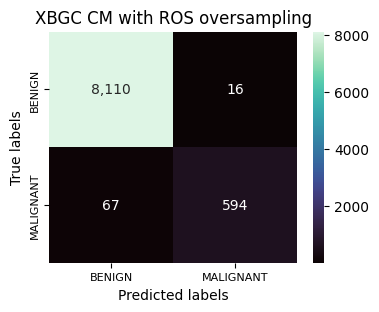

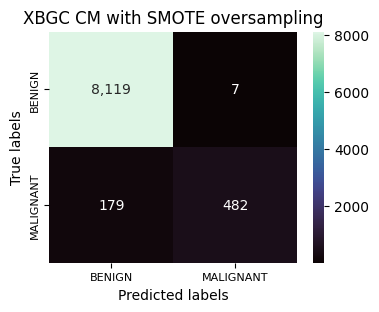

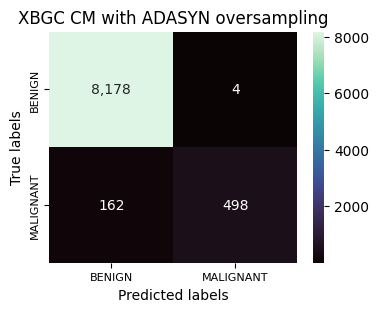

In [92]:
for n, i in enumerate(cmm):
    plot_confusion_matrix(0, 0, t=f'XBGC CM with {ust[n]} oversampling', cm=i)


In [93]:

# plot_roc_curve(y_test, yhat)


In [94]:
from lightgbm import LGBMClassifier

In [95]:
cmm=[]
clf= LGBMClassifier()
for i in ost:
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i], y_pred))
    print(i+" Oversampling :")
    report(y_test[i], y_pred)
    print("\n")


ROS Oversampling :
   Accuracy  Precision    Recall  F1 score
0  0.966428   0.946341  0.586989  0.724556


SMOTE Oversampling :
   Accuracy  Precision    Recall  F1 score
0  0.977581   0.993617  0.706505  0.825818


ADASYN Oversampling :
   Accuracy  Precision    Recall  F1 score
0  0.979643   0.989796  0.734848  0.843478




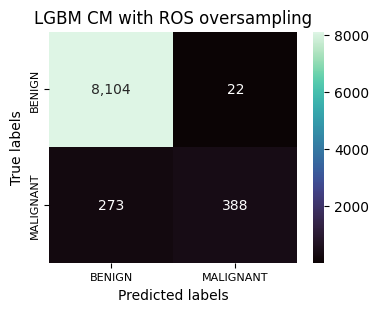

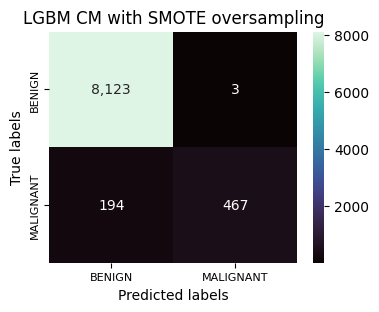

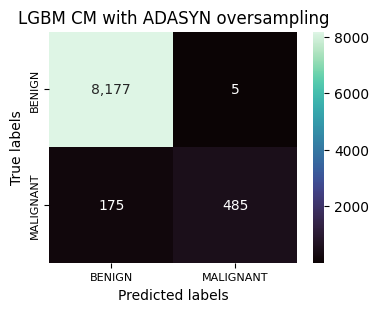

In [96]:
for n, i in enumerate(cmm):
    plot_confusion_matrix(0, 0, t=f'LGBM CM with {ost[n]} oversampling', cm=i)

In [97]:
# model = LGBMClassifier(learning_rate=0.3, n_estimators=100, num_leaves=100, random_state=42)
# model.fit(x_train, y_train)

# # Predicting the Target variable
# pred = model.predict(x_test)
# # print(pred)
# accuracy = model.score(x_test, y_test)
# print(accuracy)
# cm=confusion_matrix(y_test, pred)
# print(cm)


In [98]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
# model = AdaBoostClassifier()
# evaluate the model
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(
#     model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# # report performance
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


In [99]:
# model.fit(x_train,y_train)
# model.score(x_test,y_test)

In [101]:
cmm=[]
clf= AdaBoostClassifier(learning_rate=0.3, n_estimators=100, random_state=42)
for i in ost:
    clf = clf.fit(x_train[i], y_train[i])
    y_pred = clf.predict(x_test[i])
    cmm.append(confusion_matrix(y_test[i], y_pred))
    # print(confusion_matrix(y_test[i], y_pred))
    print(i+" Oversampling :")
    report(y_test[i], y_pred)
    print("\n")


ROS Oversampling :
   Accuracy  Precision   Recall  F1 score
0  0.924206   0.424242  0.02118  0.040346


SMOTE Oversampling :
   Accuracy  Precision   Recall  F1 score
0    0.9291   0.913043  0.06354  0.118812


ADASYN Oversampling :
   Accuracy  Precision    Recall  F1 score
0  0.928749   0.826087  0.057576  0.107649




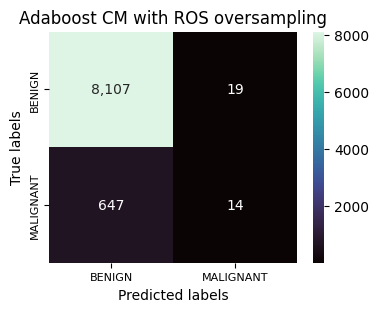

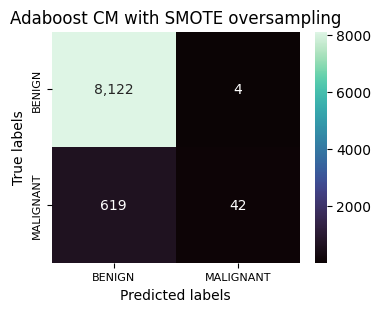

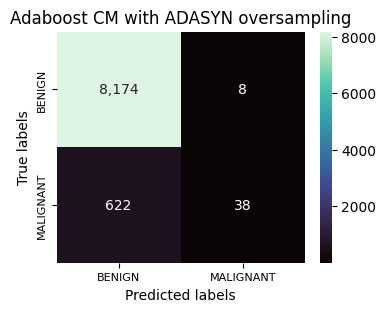

In [103]:
for n, i in enumerate(cmm):
    plot_confusion_matrix(0, 0, t=f'Adaboost CM with {ust[n]} oversampling', cm=i)


adaboost improve
gbm
catboost